In [5]:
import os, importlib, sys, time

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import scipy.linalg as la
import scipy.stats as stats

In [8]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [9]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [10]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [11]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 10

In [12]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [13]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

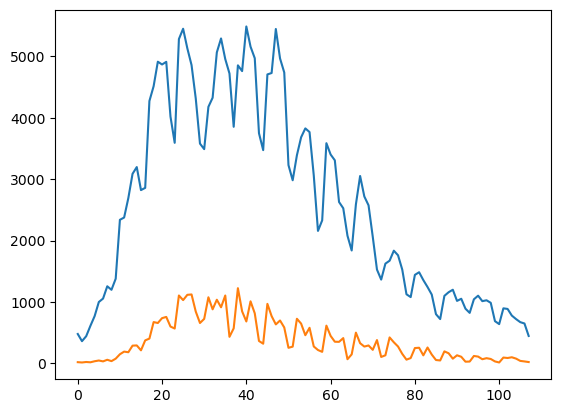

In [14]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [15]:
GPi = np.load('EuropeCovid2_GPi.npz')

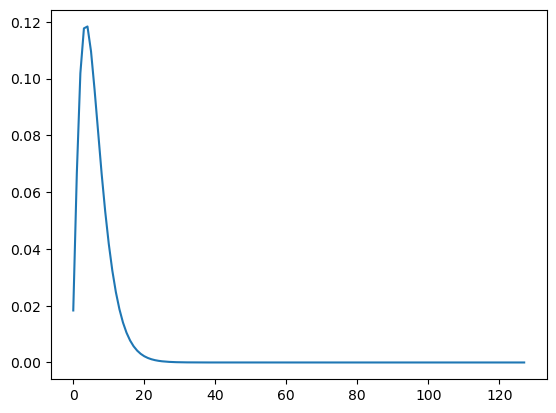

In [16]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

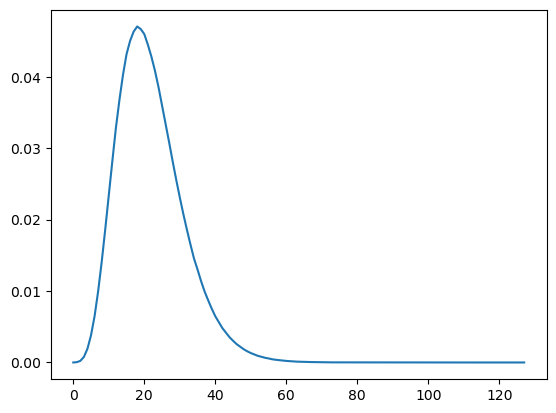

In [17]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [18]:
# A
d=2
A = np.zeros([T+T0, d])

In [19]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

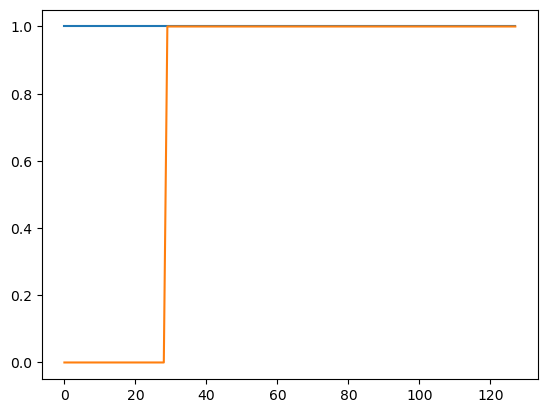

In [20]:
plt.plot(A)

# 3. fit by EM algorithm

In [21]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [22]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = [0.207, 1.872]

In [1]:
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=0.05)

NameError: name 'fit' is not defined

In [ ]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [2]:
mmle_0, smle_eps, bmle

NameError: name 'mmle_0' is not defined

## plots

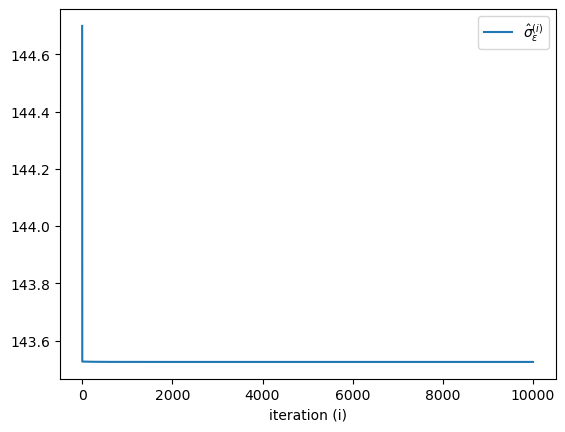

In [26]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
plt.xlabel("iteration (i)"); plt.legend()

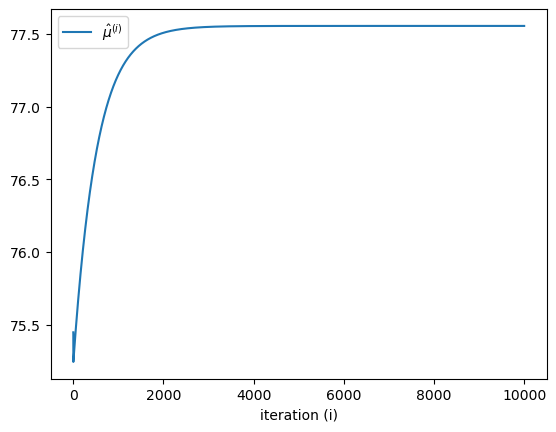

In [27]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

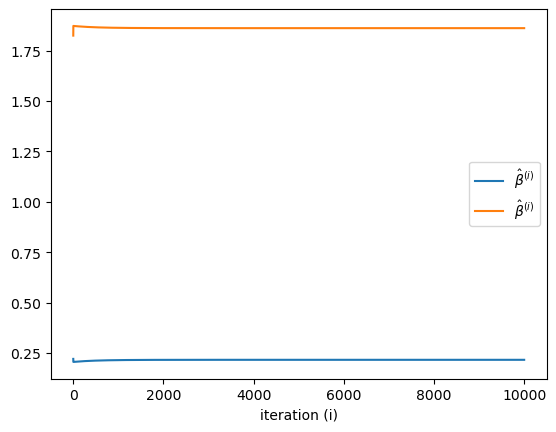

In [28]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [29]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [30]:
for t in np.arange(T+T0):
    o = np.exp(bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = - K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [31]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [32]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [33]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [34]:
Pi_inv_ImG = Pi @ inv_ImG

In [35]:
EY = mmle_0 * Pi_inv_ImG[:,0]

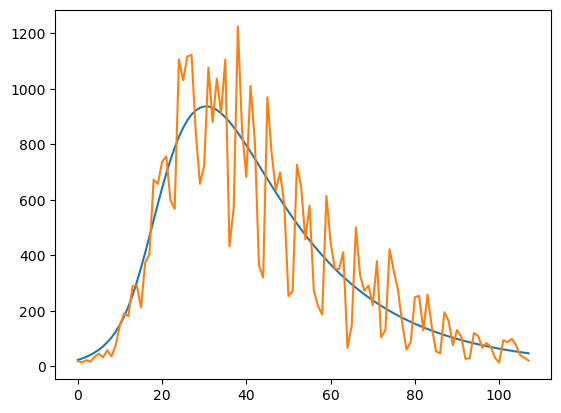

In [36]:
plt.plot(EY)
plt.plot(Y_data)

In [37]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [38]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [39]:
Ed2l_ds2 = - 2 * T / smle_eps**2
Ed2l_dsdm = 0
Ed2l_dsdb = np.zeros(d)
Ed2l_dm2 = - np.sum(Pi_inv_ImG[:,0]**2) / smle_eps**2
Ed2l_dmdb = - np.sum(Pi_inv_ImG[:,0] * d1EY, 1) / smle_eps**2
Ed2l_db2 = - d1EY @ d1EY.T / smle_eps**2

In [40]:
Ed2l_dms2 = np.array(
    [[Ed2l_dm2, Ed2l_dsdm],
     [Ed2l_dsdm, Ed2l_ds2]]
)
Ed2l_dmsdb = np.stack([Ed2l_dmdb, Ed2l_dsdb])

In [41]:
Ihat_dth = - np.block(
    [[Ed2l_dms2, Ed2l_dmsdb],
     [Ed2l_dmsdb.T, Ed2l_db2]])

In [42]:
Ihat_dth

array([[ 2.00333088e-01, -0.00000000e+00, -6.44649684e+01,
        -1.85179311e+01],
       [-0.00000000e+00,  1.04856389e-02, -0.00000000e+00,
        -0.00000000e+00],
       [-6.44649684e+01, -0.00000000e+00,  2.25824883e+04,
         7.68401239e+03],
       [-1.85179311e+01, -0.00000000e+00,  7.68401239e+03,
         3.34499410e+03]])

In [43]:
la.inv(Ihat_dth)[-2:,-2:]

array([[ 0.06176938, -0.06524389],
       [-0.06524389,  0.06952611]])

In [44]:
np.sqrt(la.inv(Ihat_dth)[2,2])

0.24853446788466402

In [45]:
np.sqrt(la.inv(Ihat_dth)[3,3])

0.2636780414591677

# 5. HAC estimator

In [46]:
# Ed2l_ds2 = T / smle_eps**2 - 3 * (Y_data-EY) @ w_HAC @ (Y_data-EY) / smle_eps**4
# Ed2l_dsdm = - 2 * Pi_inv_ImG[:,0] @ w_HAC @ (Y_data-EY) / smle_eps**3
# Ed2l_dsdb = - 2 * d1EY @ w_HAC @ (Y_data-EY) / smle_eps**3
# Ed2l_dm2 = - Pi_inv_ImG[:,0] @ w_HAC @ Pi_inv_ImG[:,0] / smle_eps**2
# Ed2l_dmdb = - d1EY @ w_HAC @ Pi_inv_ImG[:,0] / smle_eps**2
# Ed2l_db2 = - d1EY @ w_HAC @ d1EY.T / smle_eps**2

In [47]:
# Ed2l_dms2 = np.array(
#     [[Ed2l_dm2, Ed2l_dsdm],
#      [Ed2l_dsdm, Ed2l_ds2]]
# )
# Ed2l_dmsdb = np.stack([Ed2l_dmdb, Ed2l_dsdb])

In [48]:
# Ihat_HAC = - np.block(
#     [[Ed2l_dms2, Ed2l_dmsdb],
#      [Ed2l_dmsdb.T, Ed2l_db2]])

In [49]:
# Ihat_HAC

# 6. Sandwich estimator

In [50]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [51]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [52]:
dlt_dm = Pi_inv_ImG[:,0] * (Y_data - EY) / smle_eps**2
dlt_dsp = - 1 / smle_eps + (Y_data - EY)**2 / smle_eps**3
dlt_db = d1EY * (Y_data - EY) / smle_eps**2

In [53]:
dlt_dth = np.concatenate([np.array([dlt_dm, dlt_dsp]), dlt_db], 0)

In [54]:
VEdl = dlt_dth @ w_HAC @ dlt_dth.T

In [55]:
VEdl

array([[ 2.81846019e-01, -2.56584682e-02, -8.56170925e+01,
        -2.08054450e+01],
       [-2.56584682e-02,  3.14818538e-02,  9.66786161e+00,
         3.54969164e+00],
       [-8.56170925e+01,  9.66786161e+00,  2.74491000e+04,
         7.67560268e+03],
       [-2.08054450e+01,  3.54969164e+00,  7.67560268e+03,
         2.81596955e+03]])

In [56]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [57]:
Ihat_sdw

array([[ 1.83777570e-01,  6.81825265e-03, -6.50800130e+01,
        -2.33135482e+01],
       [ 6.81825265e-03,  4.49309392e-03, -3.25558770e+00,
        -1.49710978e+00],
       [-6.50800130e+01, -3.25558770e+00,  2.54538041e+04,
         1.04484985e+04],
       [-2.33135482e+01, -1.49710978e+00,  1.04484985e+04,
         4.99396188e+03]])

In [58]:
Ihat_dth

array([[ 2.00333088e-01, -0.00000000e+00, -6.44649684e+01,
        -1.85179311e+01],
       [-0.00000000e+00,  1.04856389e-02, -0.00000000e+00,
        -0.00000000e+00],
       [-6.44649684e+01, -0.00000000e+00,  2.25824883e+04,
         7.68401239e+03],
       [-1.85179311e+01, -0.00000000e+00,  7.68401239e+03,
         3.34499410e+03]])

In [59]:
la.inv(Ihat_sdw)[-2:,-2:]

array([[ 0.02480399, -0.0264004 ],
       [-0.0264004 ,  0.02861443]])

In [60]:
np.sqrt(la.inv(Ihat_sdw)[2,2])

0.15749282039524706

In [61]:
np.sqrt(la.inv(Ihat_sdw)[3,3])

0.16915800662594271